Files already downloaded and verified
Files already downloaded and verified
Training AlexNet
Using device:  cuda
batch 0 of 25
2024-11-19 02:17:43.317740 epoch: 0 train loss: 4.6223155212402345
2024-11-19 02:18:01.727385 epoch: 0 val loss: 4.591625595092774
saving  AlexNet_Scheduled.png
batch 0 of 25
2024-11-19 02:19:59.722007 epoch: 1 train loss: 4.593772125244141


KeyboardInterrupt: 

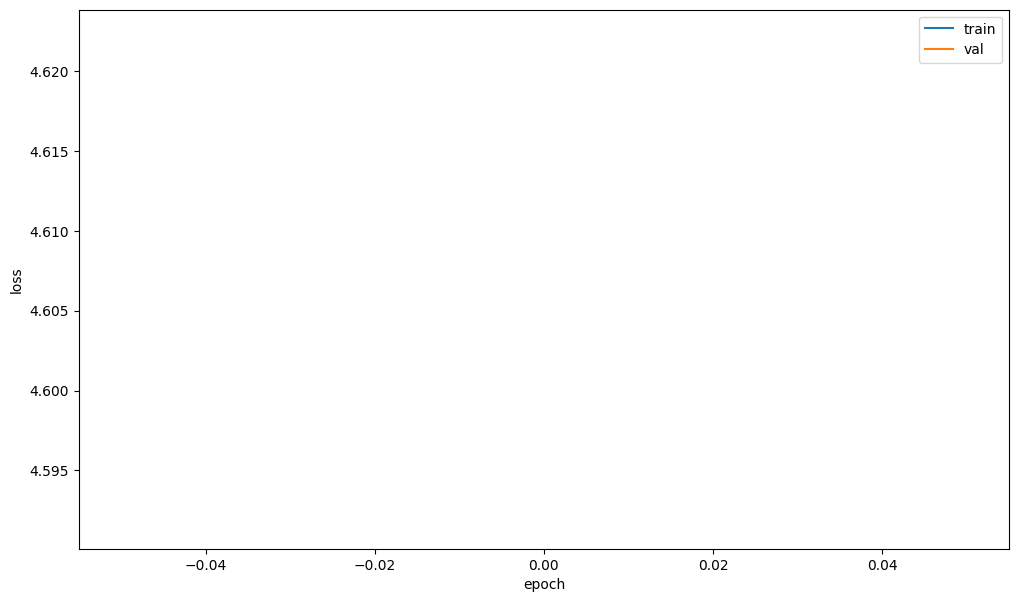

In [2]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Load CIFAR100 Dataset with fine labels
transform = transforms.Compose([transforms.Resize(227), transforms.ToTensor(), transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))])
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split train into training and validation
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define models
models_dict = {
    'AlexNet': models.alexnet(weights=None, num_classes=100),
    # 'VGG16': models.vgg16(weights=None, num_classes=100),
    # 'ResNet18': models.resnet18(weights=None, num_classes=100)
}

# Modify the classifiers to output 100 classes for CIFAR100
# for model_name, model in models_dict.items():
#     if model_name == 'AlexNet' or model_name == 'VGG16':
#       print('fitting last layer to 100')
#       model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 100)
#     elif model_name == 'ResNet18':
#       model.fc = nn.Linear(model.fc.in_features, 100)

# Training function
def train(model, device, train_loader, val_loader, num_epochs, checkpoint_epochs, save_file=None, plot_file=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        n=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if(n%25 == 0):
              print(f"batch {n} of {len(train_loader)}")
            n+=1
        avg_loss = running_loss / len(train_loader)
        scheduler.step(running_loss)
        train_losses.append(avg_loss)

        print(datetime.datetime.now(), 'epoch:', epoch, 'train loss:', avg_loss)


        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_avg_loss = val_loss / len(val_loader)
        val_losses.append(val_avg_loss)

        print(datetime.datetime.now(), 'epoch:', epoch, 'val loss:', val_avg_loss)


        if save_file != None:
            torch.save(model.state_dict(), save_file)

        if plot_file != None:
            plt.figure(2, figsize=(12, 7))
            plt.clf()
            plt.plot(train_losses, label='train')
            plt.plot(val_losses, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend(loc=1)
            print('saving ', plot_file)
            plt.savefig(plot_file)

        # Save checkpoint if at a checkpoint epoch
        if epoch + 1 in checkpoint_epochs:
            torch.save(model.state_dict(), f"{model_name}_epoch_{epoch+1}.pth")


    return train_losses, val_losses

# Testing function
def test(model, test_loader, top_k):
    model.eval()
    top1_errors, top5_errors = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, pred_top5 = outputs.topk(5, 1, largest=True, sorted=True)
            top1_errors += (pred_top5[:, 0] != labels).sum().item()
            top5_errors += (pred_top5 == labels.view(-1, 1)).sum().item()

    total_samples = len(test_loader.dataset)
    top1_error_rate = top1_errors / total_samples
    top5_error_rate = (total_samples - top5_errors) / total_samples
    return top1_error_rate, top5_error_rate

# Run the process for each model
checkpoint_epochs = [5, 50]  # Modify '50' to the desired full convergence epoch count
results = {}
for model_name, model in models_dict.items():
    print(f"Training {model_name}")
    print('Using device: ', device)
    model = model.to(device)
    train_losses, val_losses = train(model, device, train_loader, val_loader, num_epochs=50, checkpoint_epochs=checkpoint_epochs, save_file=f"{model_name}_Scheduled.pth", plot_file=f"{model_name}_Scheduled.png")

    # Test both checkpoints
    for epoch in checkpoint_epochs:
        model.load_state_dict(torch.load(f"{model_name}_epoch_{epoch}.pth"))
        top1, top5 = test(model, test_loader, top_k=5)
        results[f"{model_name}_epoch_{epoch}"] = {"top1_error": top1, "top5_error": top5}
        print(f"{model_name} Epoch {epoch} - Top-1 Error: {top1}, Top-5 Error: {top5}")

# Save or print final results
print("Final results:", results)
